# Week1 05/13
First ESN based on 'A Practical Guide to Applying  Echo State Networks' by Mantas Lukoˇseviˇcius

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ReservoirComputer:
    def __init__(self, dim_input, len_input ,dim_reservoir, dim_output, init_len, leaking_rate=0.25, beta=1e-7):
        np.random.seed(0)
        self.dim_input = dim_input
        self.len_input = len_input
        self.dim_reservoir = dim_reservoir
        self.dim_output = dim_output
        self.init_len = init_len
        self.leaking_rate = leaking_rate
        self.beta = beta
        self.W_in = np.random.rand(dim_reservoir, 1 + dim_input) - 0.5 #  (  Nx x (1+Nu)  ) with uniform distribution (between -.5 et .5)
        self.W = self.scale(np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * 1 # ( Nx x Nx) why 1.25 ?
        self.r_state = np.zeros(dim_reservoir)
        self.W_out = np.zeros((dim_output, dim_reservoir + 1 + len_input))
    def updated_state(self, u):
        ones = np.ones(1) #add bias
        self.r_state = (1 - self.leaking_rate) * self.r_state + self.leaking_rate * np.tanh(np.dot(self.W_in, np.concatenate((ones, u), axis=None)) + np.dot(self.W, self.r_state))
        return self.r_state

    def output(self, u):
        one = np.ones(1)
        return self.W_out @ np.concatenate((one, u, self.r_state), axis=None)

    def predict(self, signal, steps):
        u = signal[-1]
        prediction = np.zeros((steps, self.dim_input))
        for i in range(steps):
            self.updated_state(u)
            y = self.output(u)
            prediction[i] = y
            u = y
        self
        return prediction
        
    def scale(self, W):
        ones = np.ones(1)
        return W/np.abs(np.linalg.eigvals(W)).max()
    
    def train(self, signal, y_target): #find Wout minimizeng RMSE with regularization ?
        R = np.zeros((self.dim_reservoir, self.len_input - self.init_len)) # each column is an state at time t
                                                                            # (Nu, len_input - init_len)
        for i in range(self.len_input):
            u = signal[i]
            self.updated_state(u)
            if i>= self.init_len:
                R[:, i-self.init_len] = self.r_state
                
        signal_cut = signal[self.init_len:]
        y_target_cut = y_target[self.init_len:]
        self.R = R

        self.W_out = self.solution(signal_cut, R, y_target_cut)

    
    def solution(self, signal, R, y_target): #y_target -> (n_features, n_timestep)
        ones = np.ones((signal.shape[1], signal.shape[0]))
        X = np.concatenate((ones, signal.T, R), axis=0)
        left_part = y_target.T @ X.T
        right_part = np.linalg.inv(X @ X.T + self.beta * np.identity(X.shape[0]))
        return left_part @ right_part

    def loss(self, y_target, predictions):
        return np.mean(np.square((y_target - predictions)))

    def reset_reservoir(self):
        self.r_state = np.zeros(self.dim_reservoir)
        self.W_out = np.zeros((self.dim_output, self.dim_reservoir + 1 + self.len_input))
    
    def paramaters(self):
        print(f'Model\'s parameters')
        print(f'dim_input : {self.dim_input}')
        print(f'len_input : {self.len_input}')
        print(f'dim_reservoir : {self.dim_reservoir}')
        print(f'dim_output : {self.dim_output}')
        print(f'init_len : {self.init_len}')
        print(f'leaking rate : {self.leaking_rate}')
        print(f'regularization coefficient : {self.beta}')

        
        
        

In [7]:
steps = np.pi / 16
steps_ahead = 1000
T = np.arange(0, 200, steps, dtype=float)
n_steps = T.shape[0] - 1
u = np.sin(T)[:, None]
y_target = u[1:]
u = u[:-1]
print(u[-1])
print(f'n_steps = {n_steps}')
print(u.shape)
print(y_target.shape)


[-0.98078528]
n_steps = 1018
(1018, 1)
(1018, 1)


In [8]:
T = np.linspace(0, 600, 3000)
signal = np.sin(T)[:,None]
len_train = 1200
len_test = 800
init_len = 100
u = signal[:len_train]
y_target = signal[1: len_train +1]

In [9]:
dim_reservoir = 1000
init_len = 100
model = ReservoirComputer(1, len_train, dim_reservoir, 1, init_len)

In [10]:
print(f'spectral raduis : {np.abs(np.linalg.eigvals(model.W)).max()}')

spectral raduis : 1.0000000000000075


In [11]:
model.train(u, y_target)

In [12]:
prediction = model.predict(u, len_test)


In [13]:
T_out = np.arange(T[-1], 200 + steps_ahead * steps, steps)[-steps_ahead:]

In [14]:
print(model.R[:5].T[:200].shape)
print(prediction.shape)
print(signal[len_train + 1: len_train + len_test +1].shape)


(200, 5)
(800, 1)
(800, 1)


Model's parameters
dim_input : 1
len_input : 1200
dim_reservoir : 1000
dim_output : 1
init_len : 100
leaking rate : 0.25
regularization coefficient : 1e-07
Loss : 2.7599791268066983e-05


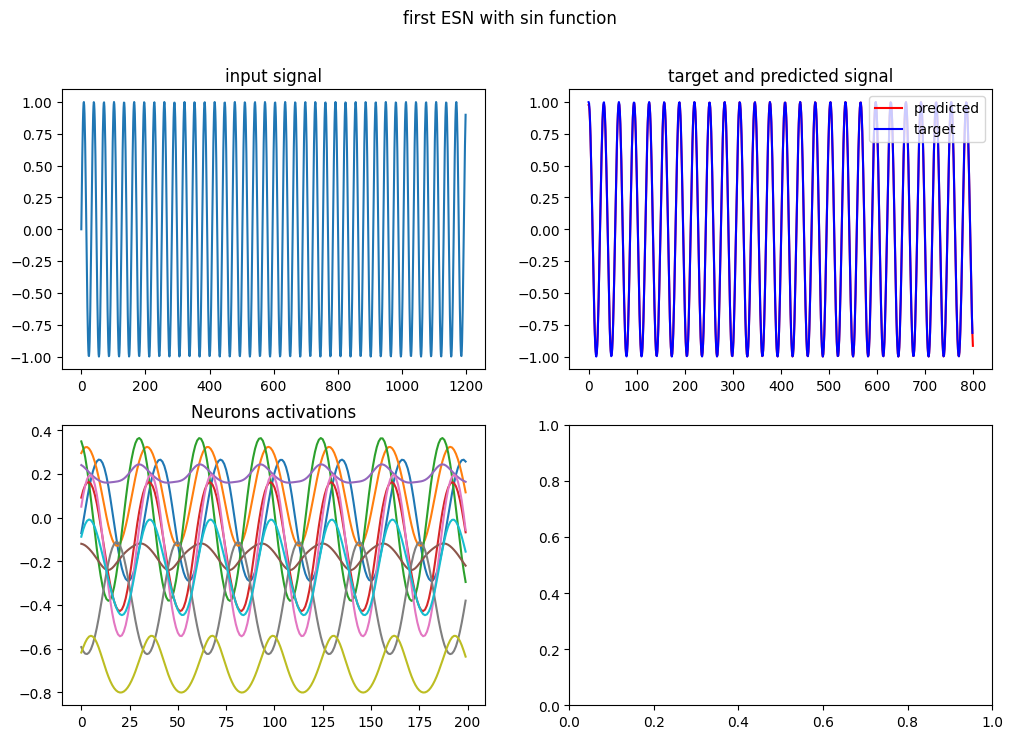

In [15]:
model.paramaters()
print(f'Loss : {model.loss(signal[len_train + 1: len_train + len_test +1], prediction)}')
fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('first ESN with sin function ')
ax[0, 0].plot(u)
ax[0, 0].set_title('input signal')

ax[0, 1].plot(prediction, label='predicted', c='red')
ax[0, 1].plot(signal[len_train + 1: len_train + len_test], label='target', c='blue')
ax[0, 1].set_title('target and predicted signal')
ax[0, 1].legend(loc=1)

ax[1, 0].plot(model.R[:10].T[:200])
ax[1, 0].set_title('Neurons activations')

plt.show()


In [16]:
len_train = 2000
len_test = 2000
init_len = 100
data = np.loadtxt('MackeyGlass_t17.txt')
data = data[:, None]
u = data[:len_train]
y_target = data[1: len_train +1] #on fait le slicing dans la classe mais on decale de 1 ici 
dim_reservoir = 1000
dim_input = 1
dim_output = dim_input


model_mackeyglass = ReservoirComputer(dim_input, len_train, dim_reservoir, dim_output, init_len, 0.3, 1e-8)
print(u.shape)
print(y_target.shape)



(2000, 1)
(2000, 1)


In [17]:
model_mackeyglass.train(u, y_target)

In [18]:
p = model_mackeyglass.predict(u, len_test)

Model's parameters
dim_input : 1
len_input : 2000
dim_reservoir : 1000
dim_output : 1
init_len : 100
leaking rate : 0.3
regularization coefficient : 1e-08
Loss : 0.026190859093769597


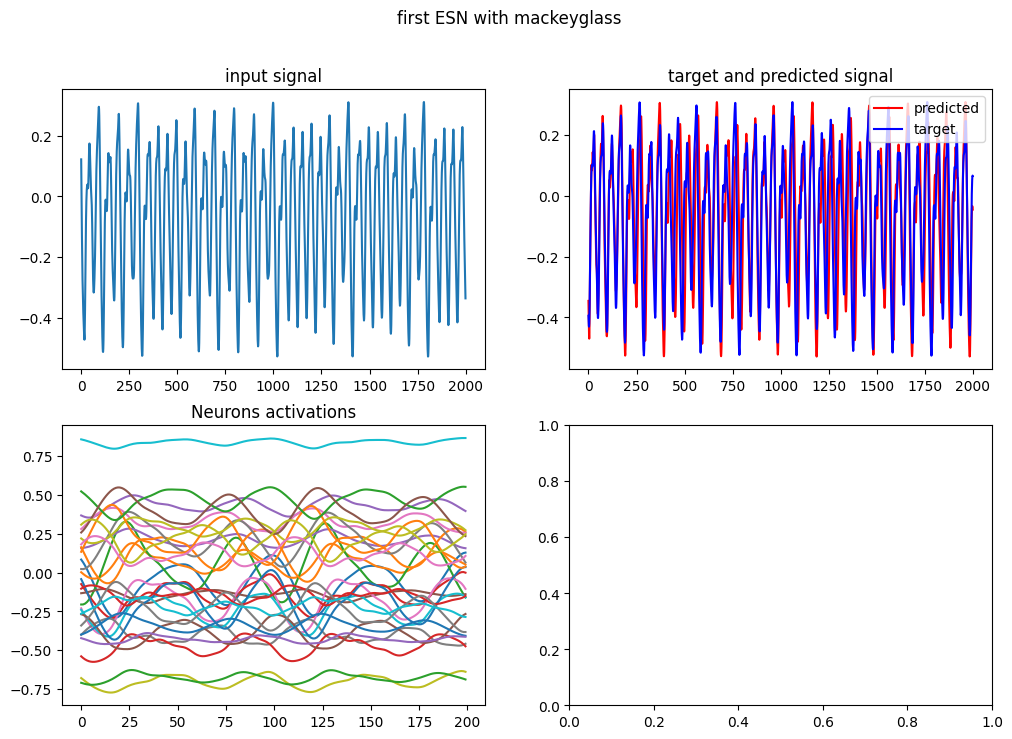

In [19]:
model_mackeyglass.paramaters()
print(f'Loss : {model_mackeyglass.loss(data[len_train + 1: len_train + len_test +1], p)}')

fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('first ESN with mackeyglass ')
ax[0, 0].plot(u)
ax[0, 0].set_title('input signal')

ax[0, 1].plot(p, label='predicted', c='red')
ax[0, 1].plot(data[len_train + 1: len_train + len_test + 1], label='target', c='blue')
ax[0, 1].set_title('target and predicted signal')
ax[0, 1].legend(loc=1)

ax[1, 0].plot(model_mackeyglass.R[:30].T[:200])
ax[1, 0].set_title('Neurons activations')

plt.show()


## Notes

- How to find a good leaking rate?
- How does it converges ?
- How to chose a good beta for ridge regression?
- Why W * 1.25?
- How to interpret neurons activations?
- Which init_len to choose to discard the inital time steps of activations for training that are affected by inital transient?
- Prop 3(b) "The echo state approach ..."


- Need to experiments differents hyperparameters ie. : distribtutions, size of the reservoir, scaling, leaking rate, beta
  

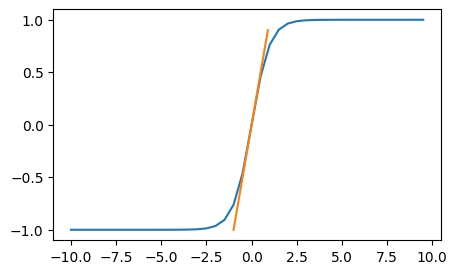

In [20]:
t1 = np.arange(-10, 10, 0.5)
plt.figure(figsize=(5,3))
plt.plot(t1, np.tanh(t1))
plt.plot(np.arange(-1,1, 0.1),np.arange(-1,1, 0.1) )
plt.show()